In [73]:
# Load relevant libraries.
# For the exact version number, please see the readme file.
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


%matplotlib inline
# %pdb on

### The Data
The dataset includes information on 2,149 patients, some diagnosed with Alzheimer’s disease and others not.<br>
Each patient has a set of features that can be categorized into four main groups:
1. Population characteristics (e.g., gender, ethnicity, education)
2. Medical indicators and background (e.g., blood pressure, weight, cholesterol, family history of Alzheimer’s)
3. Habits (e.g. smoking, alcohol consuming, physical activity)
4. Cognitive ability reports (e.g., confusion, disorientation, memory complaints)

### Our Goals
By analyzing the data we would like to achieve two goals:
1. Identifying and understanding the factors influencing Alzheimer’s disease morbidity.
2. Developing a model to predict the onset of Alzheimer’s disease in patients.

In [2]:
# Load dataset
alzheimer_dataset_path = "10_alzheimers_disease_data.csv"
alz_df = pd.read_csv(alzheimer_dataset_path)

#The first and the last columns ('PatientID', 'DoctorInCharge') contains no-relevant data for our research. let's remove them:
alz_df = alz_df.drop(['PatientID', 'DoctorInCharge'], axis=1)
alz_df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [3]:
# Count the total number of patients, as well as the number of diagnosed and non-diagnosed patients.
num_of_patients = alz_df.shape[0]
count_alzheimer = alz_df['Diagnosis'].value_counts()[1]
count_no_alzheimer = alz_df['Diagnosis'].value_counts()[0]
diagnosis_data = {
    'Diagnosis': ['Alzheimer', 'No Alzheimer'],
    'Count': [count_alzheimer, count_no_alzheimer]
}
diagnosis_df = pd.DataFrame(diagnosis_data)

Now, let's "feel" the data by some infographics.

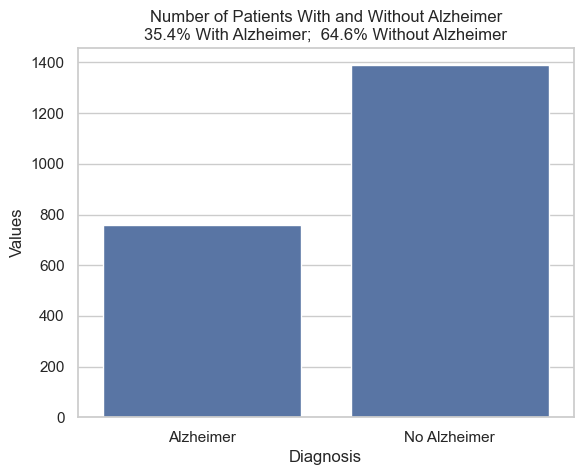

In [4]:
sns.set(style="whitegrid")
sns.barplot(x='Diagnosis', y='Count', data=diagnosis_df)
plt.title('Number of Patients With and Without Alzheimer\n'
          + str(round(100 * count_alzheimer / num_of_patients, 1)) + '% With Alzheimer'  + ';  ' + str(round(100 * count_no_alzheimer / num_of_patients, 1)) + '% Without Alzheimer')
plt.xlabel('Diagnosis')
plt.ylabel('Values')
plt.show()

**Explain**: The dataset contains information on 1,389 healthy patients and 760 diagnosed patients. Since the data is significantly imbalanced, we need to consider this when training models.

### Binary Features and Their Impact on Diagnosis
Let’s analyze how certain binary features influence the diagnosis.<br>
We use the conditional probabilty formula: $ P(A|B) = P(A\cap B) / P(B) $.

In [5]:
def PlotCondProbSubplot(col_name, subplot_axes, feature_name, zero_feature_name, one_feature_name):
    """
    Plots a bar chart of conditional probabilities for a given feature in the Alzheimer's dataset.

    Parameters:
    col_name (str): The name of the column in the DataFrame to analyze.
    subplot_axes (matplotlib.axes.Axes): The axes object where the plot will be drawn.
    feature_name (str): The name of the feature to be displayed on the x-axis.
    zero_feature_name (str): The label for the feature value 0.
    one_feature_name (str): The label for the feature value 1.

    The function calculates the conditional probabilities of being diagnosed with Alzheimer's
    given the binary values (0 or 1) of the specified feature. It then plots these probabilities
    as a bar chart on the provided subplot axes.
    """
    count_zeros = alz_df[col_name].value_counts()[0]
    count_ones = alz_df[col_name].value_counts()[1]
    count_alz_zeros = ((alz_df[col_name] == 0) & (alz_df['Diagnosis'] == 1)).sum()
    count_alz_ones = ((alz_df[col_name] == 1) & (alz_df['Diagnosis'] == 1)).sum()

    subplot_data = {
        feature_name: [zero_feature_name, one_feature_name],
        'Prob': [count_alz_zeros / count_zeros, count_alz_ones / count_ones]
    }
    subplot_df = pd.DataFrame(subplot_data)

    sns.barplot(x=feature_name, y='Prob', data=subplot_df, ax=subplot_axes, width=0.4)
    subplot_axes.set_ylabel('Probability')
    subplot_axes.set_ylim([0, 1])

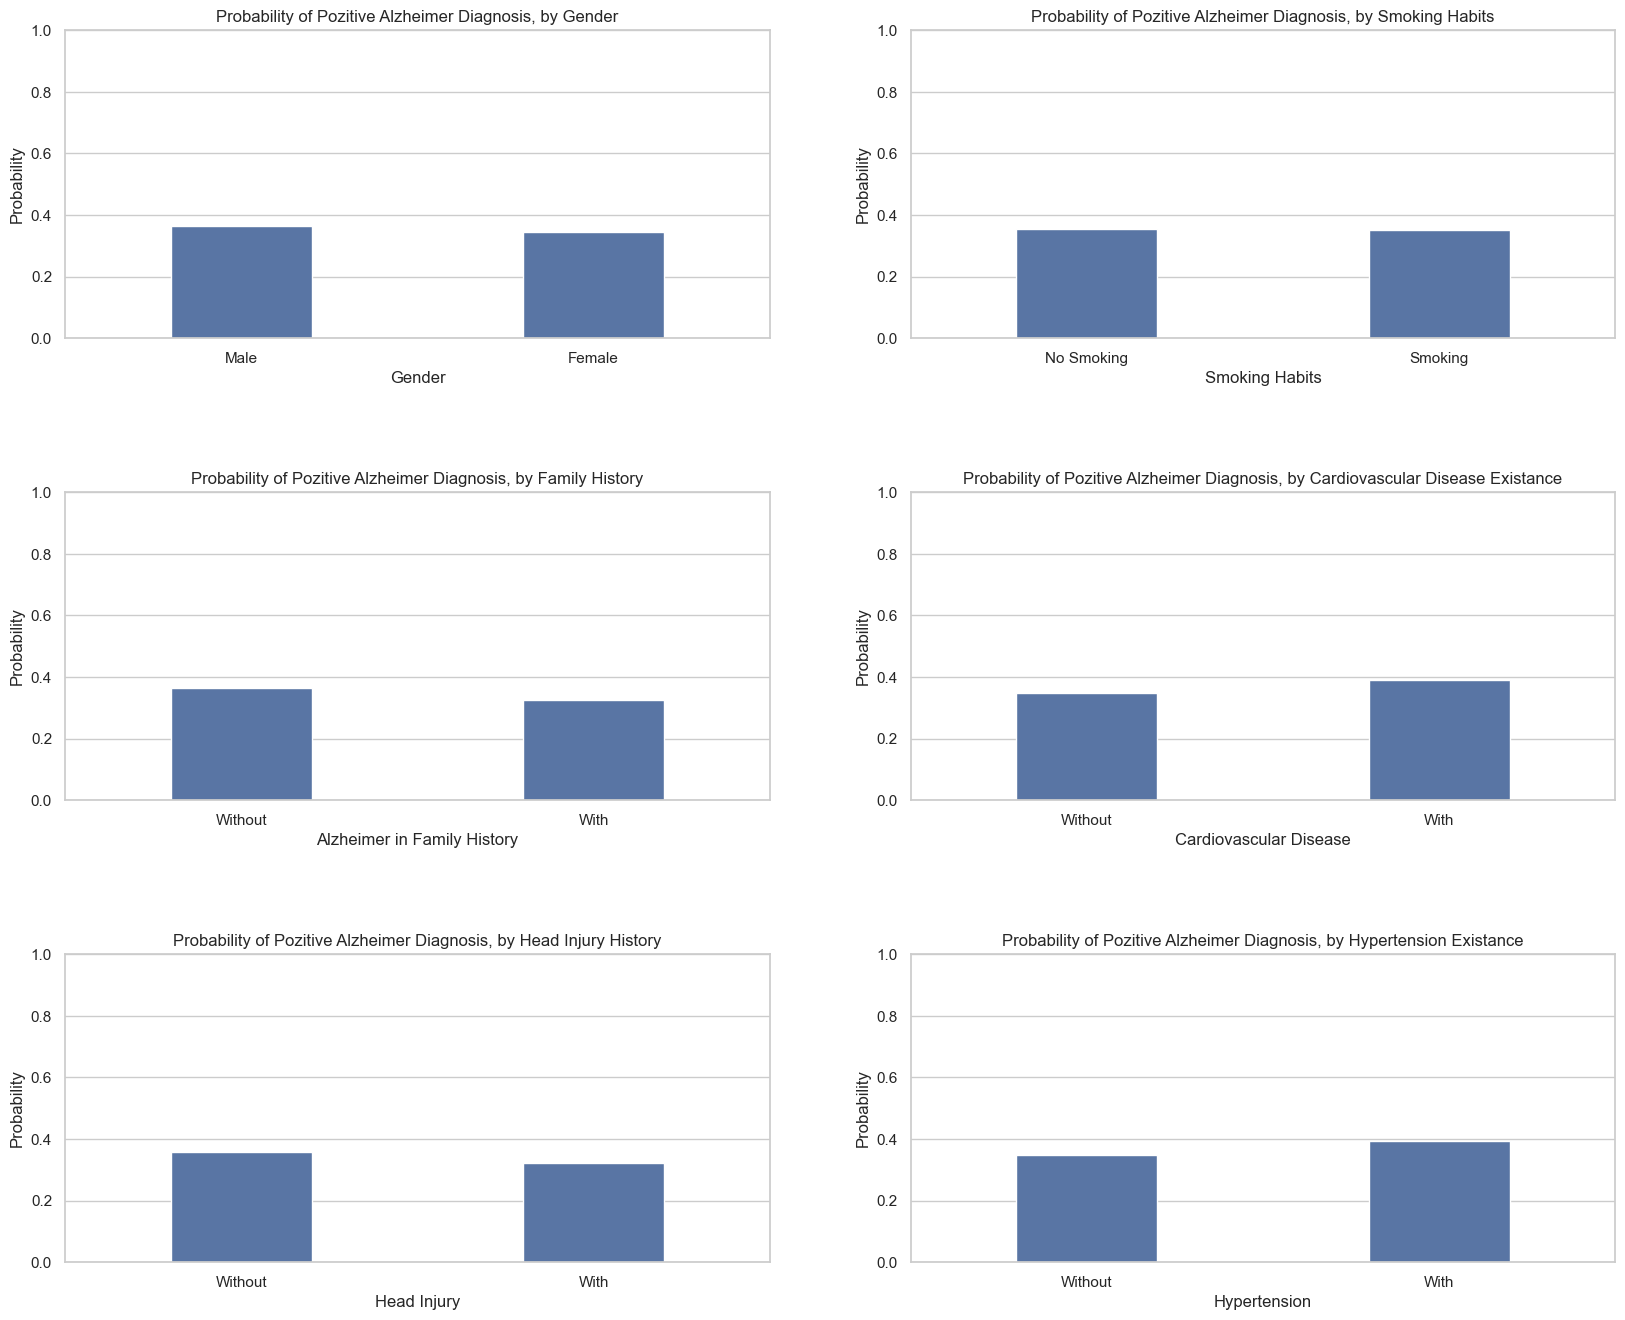

In [6]:
# Create the figure and plot the conditional probabilities for the binary features
fig, axes = plt.subplots(3, 2, figsize=(20, 16))
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.2)

PlotCondProbSubplot('Gender', axes[0, 0], 'Gender', 'Male', 'Female')
axes[0, 0].set_title('Probability of Pozitive Alzheimer Diagnosis, by Gender');

PlotCondProbSubplot('Smoking', axes[0, 1], 'Smoking Habits', 'No Smoking', 'Smoking')
axes[0, 1].set_title('Probability of Pozitive Alzheimer Diagnosis, by Smoking Habits');

PlotCondProbSubplot('FamilyHistoryAlzheimers', axes[1, 0], 'Alzheimer in Family History', 'Without', 'With')
axes[1, 0].set_title('Probability of Pozitive Alzheimer Diagnosis, by Family History');

PlotCondProbSubplot('CardiovascularDisease', axes[1, 1], 'Cardiovascular Disease', 'Without', 'With')
axes[1, 1].set_title('Probability of Pozitive Alzheimer Diagnosis, by Cardiovascular Disease Existance');

PlotCondProbSubplot('HeadInjury', axes[2, 0], 'Head Injury', 'Without', 'With')
axes[2, 0].set_title('Probability of Pozitive Alzheimer Diagnosis, by Head Injury History');

PlotCondProbSubplot('Hypertension', axes[2, 1], 'Hypertension', 'Without', 'With')
axes[2, 1].set_title('Probability of Pozitive Alzheimer Diagnosis, by Hypertension Existance');

**Explain:** It appears that no single binary characteristic definitively distinguishes Alzheimer’s patients.<br>
In this analysis, we focused exclusively on objective factors (groups 1-3), excluding reported symptoms (group 4), as these typically emerge only after the disease has developed in the patient.


### Correlation Matrix
To gain a comprehensive understanding of the relationship between each feature and the diagnosis, let’s calculate and examine the correlation matrix. While the covariance matrix measures the direction of the joint linear relationship between two variables, the correlation matrix normalizes the covariance to provide both the strength and direction of the relationship.<br>

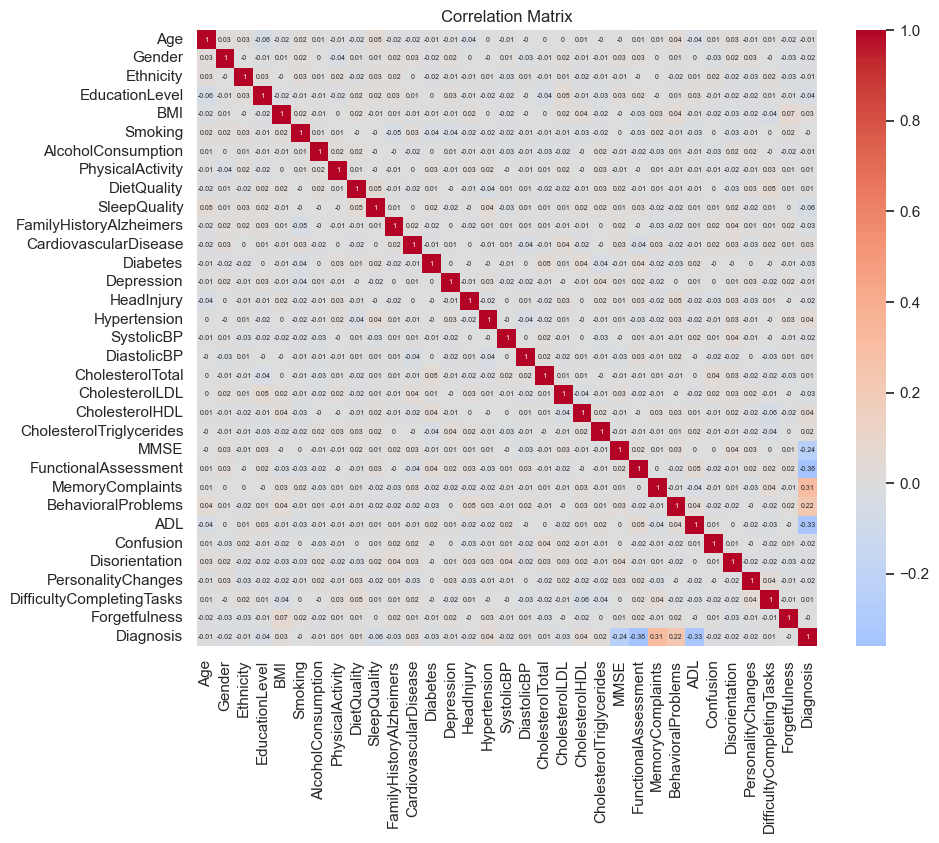

In [7]:
# Calculate correlation matrix
correlation_matrix = alz_df.corr()
correlation_matrix = round(correlation_matrix, 2)

# Get correlation with the label
diagnosis_correlation = correlation_matrix['Diagnosis'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={"size": 5})
plt.title('Correlation Matrix')
plt.show()

**Explain:** The last row (or column) in the matrix is the most significant, as it represents the correlation between each feature and the ‘Diagnosis’ label. We observe strong correlations between the diagnosis and the following features:
- MMSE (Mini-Mental State Examination)
- Functional assessment
- Memory complaints
- Behavioral problems
- ADL (Activities of Daily Living score)

These results are neither surprising nor particularly useful, as they highlight symptoms of Alzheimer’s rather than identifying potential causative factors (such as BMI, cholesterol values, etc.).

### Predictive Model and Feature Combination for Prediction
We will remove the consequential features from the DataFrame and build a predictive model to gain a clearer understanding of the relationships between the disease and its causes.<br>

Before building and training the model, let’s check for any outliers that need to be removed from our data.<br>
We use *one class SVM* in order to identify the outliers.

In [8]:
# The columns contain relevant continous data:
continuous_columns = ['BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides']

scaler = StandardScaler()
alz_df_scaled = alz_df.copy()
alz_df_scaled[continuous_columns] = scaler.fit_transform(alz_df_scaled[continuous_columns])

# Initialize and train the One-Class SVM model.
# We choose relatively small nu, because we don't want to lose a lot of data.
ocsvm_model = OneClassSVM(kernel='rbf', nu=0.05)
ocsvm_model.fit(alz_df_scaled)

# Predict outliers
predictions = ocsvm_model.predict(alz_df_scaled)

# Filter out the outliers
alz_df['outlier'] = predictions
alz_df_inliers = alz_df[alz_df['outlier'] == 1]
alz_df_outliers = alz_df[alz_df['outlier'] == -1]

print("Rate of Outliers:")
print(str(len(alz_df_outliers)) + '/' + str(len(alz_df)))

alz_df = alz_df_inliers
alz_df = alz_df.drop('outlier', axis=1)

Rate of Outliers:
107/2149


In [9]:
features_df = alz_df.copy()
# features_df = features_df.drop(
#     columns=['MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis'],
#     axis=1)
features_df = features_df.drop(columns=['Diagnosis'], axis=1)
labels = alz_df['Diagnosis']

#Split the data to train set and test set
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

### The Models
We will develop various classification models and evaluate their predictive accuracy for diagnosing Alzheimer’s disease.<br>

The classifiers we will use are:
- KNN
- SVM
- Random Forest
- CatBoost
- Gradient Boosting

In [18]:
def EstimateModelAccuracy(model, model_name, X_train, X_test, y_train, y_test, subplot_axes):
    """
    Estimates and prints the accuracy and Matthews correlation coefficient (MCC) of a given model.
    Also displays confusion matrices for both the training and test datasets using provided subplot axes.

    Parameters:
    model (object): The machine learning model to evaluate.
    model_name (str): The name of the model, used for display purposes.
    X_train (array-like): The training input samples.
    X_test (array-like): The test input samples.
    y_train (array-like): The true labels for the training input samples.
    y_test (array-like): The true labels for the test input samples.
    subplot_axes (list of matplotlib.axes.Axes): List containing two subplot axes for plotting confusion matrices.

    Returns:
    tuple: A tuple containing the accuracy and MCC of the model on the test set.

    The function performs the following steps:
    1. Predicts the labels for the training set and plots the confusion matrix.
    2. Predicts the labels for the test set and plots the confusion matrix.
    3. Calculates and returns the accuracy and MCC for the test set.
    """
    
    # "Predict" and plot confusion matrix based on TRAINING set 
    y_pred_train = model.predict(X_train)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train)
    subplot_axes_train = subplot_axes[0]
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', ax=subplot_axes_train)
    subplot_axes_train.set_title(model_name + '\nConfusion Matrix - Training Set')
    subplot_axes_train.set_xlabel('Predicted')
    subplot_axes_train.set_ylabel('Actual')
    
    # Predict and plot confusion matrix based on TEST set
    y_pred = model.predict(X_test)
    conf_matrix_test = confusion_matrix(y_test, y_pred)
    subplot_axes_test = subplot_axes[1]
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', ax=subplot_axes_test)
    subplot_axes_test.set_title(model_name + '\nConfusion Matrix - Test Set')
    subplot_axes_test.set_xlabel('Predicted')
    subplot_axes_test.set_ylabel('Actual')
    
    # Accuracy and MCC
    accuracy = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    plt.show()

    return (accuracy, mcc)

,model_name,model_obj,accuracy,mcc
0,KNN,KNeighborsClassifier(n_neighbors=7),0.579462,0.041272
1,RBF SVM,SVC(class_weight='balanced'),0.562347,0.102817
2,RandomForest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.926650,0.846171
3,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,0.958435,0.912554
4,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,0.953545,0.902225


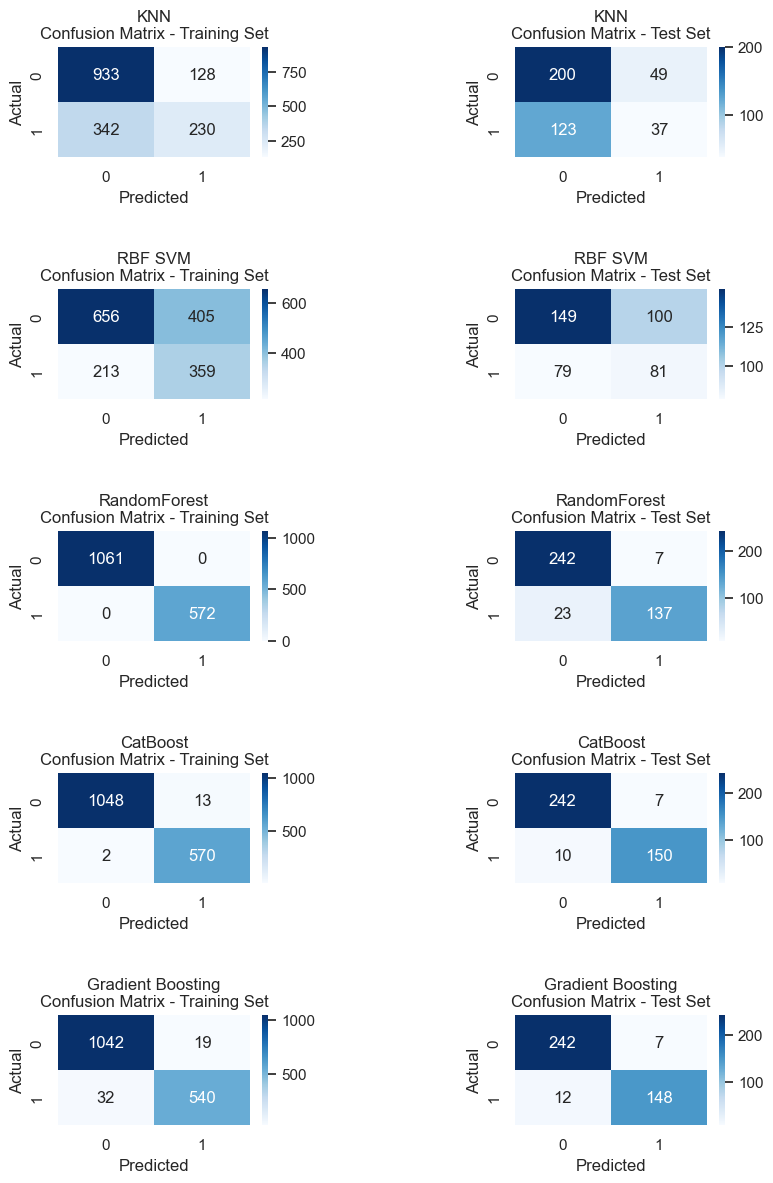

In [80]:
# create subplots figure for confusion matrices
fig, axes = plt.subplots(5, 2, figsize=(9, 14))
plt.subplots_adjust(hspace=1.2)
plt.subplots_adjust(wspace=0.9)

models_score_df = pd.DataFrame(columns=['model_name', 'model_obj', 'accuracy', 'mcc'])

# KNN
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
(accuracy, mcc) = EstimateModelAccuracy(knn_model, 'KNN', X_train, X_test, y_train, y_test, (axes[0, 0], axes[0, 1]));
models_score_df.loc[0] = ['KNN', knn_model, accuracy, mcc]

# SVM with a Radial Basis Function kernel
rbf_svm_model = SVC(kernel='rbf', class_weight='balanced')
rbf_svm_model.fit(X_train, y_train)
(accuracy, mcc) = EstimateModelAccuracy(rbf_svm_model, 'RBF SVM', X_train, X_test, y_train, y_test, (axes[1, 0], axes[1, 1]));
models_score_df.loc[1] = ['RBF SVM', rbf_svm_model, accuracy, mcc]

# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train);
(accuracy, mcc) = EstimateModelAccuracy(rf_model, 'RandomForest', X_train, X_test, y_train, y_test, (axes[2, 0], axes[2, 1]))
models_score_df.loc[2] = ['RandomForest', rf_model, accuracy, mcc]

# CatBoostClassifier
catboost_model = CatBoostClassifier(auto_class_weights='Balanced', verbose=False)
catboost_model.fit(X_train, y_train);
(accuracy, mcc) = EstimateModelAccuracy(catboost_model, 'CatBoost', X_train, X_test, y_train, y_test, (axes[3, 0], axes[3, 1]));
models_score_df.loc[3] = ['CatBoost', catboost_model, accuracy, mcc]

# Gradient Boosting
gradboost_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gradboost_model.fit(X_train, y_train);
(accuracy, mcc) = EstimateModelAccuracy(gradboost_model, 'Gradient Boosting', X_train, X_test, y_train, y_test, (axes[4, 0], axes[4, 1]));
models_score_df.loc[4] = ['Gradient Boosting', gradboost_model, accuracy, mcc]

models_score_df

**Explain:** The classifier with the best results is the CatBoost. In order to receive even better results, let's try to finetune the model hyperparameters.<br>
We will construct a grid of hyperparameters centered around the model’s default values and conduct a grid search to evaluate every possible combination. Finally, we will select the combination that yields the most accurate model and determine if this improves the model’s accuracy compared to the default settings.

In [ ]:
# Create the hyperparameters grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [500, 1000, 2000]
}
train_pool = Pool(X_train, y_train)

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Initialize the model with the best parameters
catboost_finetuned_model = CatBoostClassifier(**best_params, silent=True)

# Train the model
catboost_finetuned_model.fit(X_train, y_train)

# Plot the confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(7, 2))
plt.subplots_adjust(wspace=0.4)
(accuracy, mcc) = EstimateModelAccuracy(catboost_finetuned_model, 'CatBoost Model after Finetuning', X_train, X_test, y_train, y_test, (axes[0], axes[1]));
models_score_df.loc[5] = ['CatBoost Model after Finetuning', catboost_finetuned_model, accuracy, mcc]

models_score_df

**Explain**: Even after fine-tuning, we couldn’t enhance the model’s accuracy. Therefore, the original CatBoost model remains the most effective in predicting Alzheimer’s disease, achieving an **accuracy of 0.958 and MCC of 0.91**.

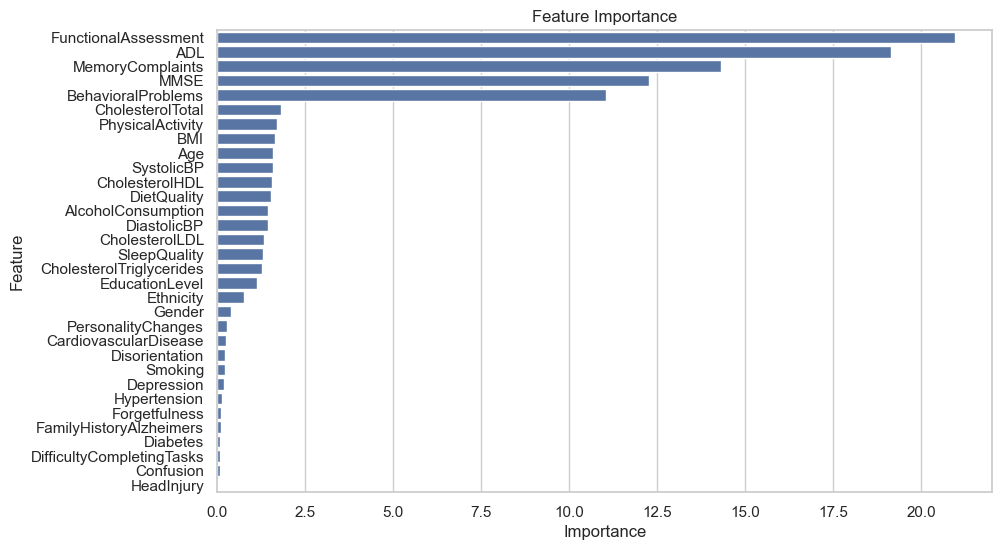

In [63]:
# Get feature importances
importances = catboost_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features_df.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

**Explain:** As observed in the correlation matrix, the most significant predictors in the model that yielded the best results are the reported symptoms (group 4 features): Functional Assessment, ADL, Memory Complaints, etc.

### Predictive Model and Feature Combination for Prediction - WITHOUT COGNITIVE ABILITY FEATURES
To make the task more challenging (and less straightforward), we will attempt to create a prediction model without including the cognitive ability report features. This approach is based on the fact that cognitive decline typically occurs after the onset of Alzheimer’s disease. Our goal is to develop a model that can predict the diagnosis of the disease **before** the symptoms of cognitive decline appear, essentially before the disease fully manifests.<br>
To achieve this, we will exclude the features from group 4 (Cognitive ability reports) from our dataset and repeat the model training process.